In [1]:
import numpy as np

data = np.load("path_to_save/plotting_data.npz")

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

import torch
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms

In [5]:
def plot_multi_histogram(ax, metrics_dict, title, xlabel):
    """
    Plot histogram with all four epsilon variants overlaid.

    Args:
        ax: matplotlib axis
        metrics_dict: dictionary with keys like "high_linf", "low_linf", "high_l2", "low_l2"
        title: plot title
        xlabel: x-axis label
    """
    # Updated consistent color scheme
    colors = {
        "high_linf": "red",
        "low_linf": "blue",
        "high_l2": "orange",
        "low_l2": "green",
    }

    labels = {
        "high_linf": "High L∞ Eps",
        "low_linf": "Low L∞ Eps",
        "high_l2": "High L₂ Eps",
        "low_l2": "Low L₂ Eps",
    }

    for key, data in metrics_dict.items():
        if data is not None and len(data) > 0:
            sns.histplot(
                data,
                bins=30,
                color=colors[key],
                label=labels[key],
                stat="density",
                kde=True,
                # Reduced opacity for better overlap visibility
                alpha=0.4,
                ax=ax,
            )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")
    ax.legend(fontsize="small")
    ax.grid(True, alpha=0.3)


def plot_multi_ssim_distribution(ax, data_dict, title):
    """
    Plot SSIM distribution with all four epsilon variants overlaid.

    Args:
        ax: matplotlib axis
        data_dict: dictionary with ssim values for each variant
        title: plot title
    """
    # Updated consistent color scheme
    colors = {
        "high_linf": "red",
        "low_linf": "blue",
        "high_l2": "orange",
        "low_l2": "green",
    }

    labels = {
        "high_linf": "High L∞ Eps",
        "low_linf": "Low L∞ Eps",
        "high_l2": "High L₂ Eps",
        "low_l2": "Low L₂ Eps",
    }

    for key, ssim_values in data_dict.items():
        if ssim_values is not None and len(ssim_values) > 0:
            sns.histplot(
                ssim_values,
                bins=30,
                kde=True,
                color=colors[key],
                label=labels[key],
                # Reduced opacity for better overlap visibility
                alpha=0.4,
                ax=ax,
            )

    ax.set_title(f"{title} - SSIM Distribution")
    ax.set_xlabel("SSIM")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize="small")


def compute_ssim_values(clean_images, perturbed_images):
    """
    Compute SSIM values between clean and perturbed images.

    Args:
        clean_images: clean image tensors
        perturbed_images: perturbed image tensors

    Returns:
        list of SSIM values
    """
    ssim_values = []

    for i in range(min(clean_images.size(0), perturbed_images.size(0))):
        clean_img = clean_images[i].permute(1, 2, 0).cpu().numpy()
        perturbed_img = perturbed_images[i].permute(1, 2, 0).cpu().numpy()

        # Calculate SSIM with data_range set to 1 (assuming images are [0, 1] range)
        ssim_index = ssim(clean_img, perturbed_img, channel_axis=-1, data_range=1)
        ssim_values.append(ssim_index)

    return ssim_values


def plot_misclassification_rates(data, variant, ax):
    """
    Plot misclassification rates for all variants (Linf and L2).

    Args:
        data: dictionary containing misclassification rate data
        variant: variant name ("normal", "mask", or "mask_plus_random")
        ax: matplotlib axis
    """
    # Updated consistent color scheme
    colors = {
        "low_linf": "blue",
        "high_linf": "red",
        "low_l2": "green",
        "high_l2": "orange",
    }

    # Collect keys
    keys = {
        "low_linf": f"misclass_low_{variant}",
        "high_linf": f"misclass_high_{variant}",
        "low_l2": f"misclass_low_l2_{variant}",
        "high_l2": f"misclass_high_l2_{variant}",
    }

    # Collect data
    values = {}
    for key_type, data_key in keys.items():
        if data_key in data:
            values[key_type] = data[data_key].mean() * 100  # Convert to percentage
        else:
            print(f"Warning: Missing misclassification data for {data_key}")
            values[key_type] = 0

    # Plot bars
    bar_positions = np.arange(len(values))
    width = 0.7

    bars = ax.bar(
        bar_positions, values.values(), width, color=[colors[k] for k in values.keys()]
    )

    # Labels for bars
    labels = {
        "low_linf": "Low L∞",
        "high_linf": "High L∞",
        "low_l2": "Low L₂",
        "high_l2": "High L₂",
    }

    ax.set_xticks(bar_positions)
    ax.set_xticklabels([labels[k] for k in values.keys()])

    # Formatting
    variant_labels = {
        "normal": "Adversarial",
        "mask": "Mask Only",
        "mask_plus_random": "Mask + Random",
    }

    ax.set_ylabel("Misclassification Rate (%)")
    ax.set_title(f"Misclassification Rates: {variant_labels[variant]}")
    ax.grid(True, axis="y", linestyle="--", alpha=0.7)

    # Add text labels above the bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 1,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
        )

    return ax


def plot_metrics_panel(data, clean_images, image_data, l2_image_data, variant):
    """
    Plot a 2x2 panel of metrics for a given variant with all four epsilon types.

    Args:
        data: npz data with metrics
        clean_images: original clean images
        image_data: dictionary with L∞ images
        l2_image_data: dictionary with L₂ images
        variant: variant name ("normal", "mask", or "mask_plus_random")
    """
    variant_labels = {
        "normal": "Adversarial",
        "mask": "Mask Only",
        "mask_plus_random": "Mask + Random",
    }

    # Set up 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Extract data for the variant
    metrics_dict = {
        "kl": {
            "high_linf": data.get(f"kl_high_{variant}"),
            "low_linf": data.get(f"kl_low_{variant}"),
            "high_l2": data.get(f"kl_high_l2_{variant}"),
            "low_l2": data.get(f"kl_low_l2_{variant}"),
        },
        "tvd": {
            "high_linf": data.get(f"tvd_high_{variant}"),
            "low_linf": data.get(f"tvd_low_{variant}"),
            "high_l2": data.get(f"tvd_high_l2_{variant}"),
            "low_l2": data.get(f"tvd_low_l2_{variant}"),
        },
        "conf_drop": {
            "high_linf": data.get(f"conf_drop_high_{variant}"),
            "low_linf": data.get(f"conf_drop_low_{variant}"),
            "high_l2": data.get(f"conf_drop_high_l2_{variant}"),
            "low_l2": data.get(f"conf_drop_low_l2_{variant}"),
        },
    }

    # Plot KL Divergence (top-left)
    plot_multi_histogram(
        axes[0],
        metrics_dict["kl"],
        f"KL Divergence: {variant_labels[variant]}",
        "KL Divergence",
    )

    # Plot Total Variation Distance (top-right)
    plot_multi_histogram(
        axes[1],
        metrics_dict["tvd"],
        f"Total Variation Distance: {variant_labels[variant]}",
        "TV Distance",
    )

    # Plot Confidence Drop (bottom-left)
    plot_multi_histogram(
        axes[2],
        metrics_dict["conf_drop"],
        f"Confidence Drop: {variant_labels[variant]}",
        "Confidence Drop",
    )

    # Compute SSIM values
    low_linf_images, high_linf_images = image_data[variant]
    low_l2_images, high_l2_images = l2_image_data[variant]

    ssim_values = {
        "high_linf": compute_ssim_values(clean_images, high_linf_images),
        "low_linf": compute_ssim_values(clean_images, low_linf_images),
        "high_l2": compute_ssim_values(clean_images, high_l2_images),
        "low_l2": compute_ssim_values(clean_images, low_l2_images),
    }

    # Plot SSIM Distribution (bottom-right)
    plot_multi_ssim_distribution(axes[3], ssim_values, variant_labels[variant])

    plt.tight_layout()
    plt.suptitle(f"Metrics for {variant_labels[variant]} Attack", y=1.02, fontsize=16)
    plt.subplots_adjust(top=0.92)

    return fig


def plot_misclassification_rates_panel(data):
    """
    Plot a panel showing misclassification rates for all variants and epsilons.

    Args:
        data: npz data with metrics
    """
    variants = ["normal", "mask", "mask_plus_random"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, variant in enumerate(variants):
        plot_misclassification_rates(data, variant, axes[i])

    plt.tight_layout()
    plt.suptitle(
        "Misclassification Rates Across Attack Types and Norms", y=1.02, fontsize=16
    )
    plt.subplots_adjust(top=0.85)

    return fig


def main_plotting_function(clean_images, image_data, l2_image_data, npz_data):
    """
    Main function to generate all plots.

    Args:
        clean_images: original clean images
        image_data: dictionary with L∞ norm images
        l2_image_data: dictionary with L₂ norm images
        npz_data: npz file with metrics data
    """
    # 1. First plot the misclassification rates panel with all variants
    plot_misclassification_rates_panel(npz_data)

    # 2. Plot metrics panels for each variant
    variants = ["normal", "mask", "mask_plus_random"]

    for variant in variants:
        plot_metrics_panel(
            data=npz_data,
            clean_images=clean_images,
            image_data=image_data,
            l2_image_data=l2_image_data,
            variant=variant,
        )

In [6]:
# Load npz file
npz_data = np.load("path_to_save/plotting_data.npz")

# Load original clean images (assuming you saved them)
# clean_images = torch.load("path_to_save/clean_images.pt")

# Load L∞ norm images
linf_image_data = {
    "normal": (
        torch.load("path_to_save/normal_low_dataset/data.pt"),
        torch.load("path_to_save/normal_high_dataset/data.pt")
    ),
    "mask": (
        torch.load("path_to_save/mask_low_dataset/data.pt"),
        torch.load("path_to_save/mask_high_dataset/data.pt")
    ),
    "mask_plus_random": (
        torch.load("path_to_save/mask_plus_random_low_dataset/data.pt"),
        torch.load("path_to_save/mask_plus_random_high_dataset/data.pt")
    )
}

# Load L₂ norm images
l2_image_data = {
    "normal": (
        torch.load("path_to_save/l2_normal_low_dataset/data.pt"),
        torch.load("path_to_save/l2_normal_high_dataset/data.pt")
    ),
    "mask": (
        torch.load("path_to_save/l2_mask_low_dataset/data.pt"),
        torch.load("path_to_save/l2_mask_high_dataset/data.pt")
    ),
    "mask_plus_random": (
        torch.load("path_to_save/l2_mask_plus_random_low_dataset/data.pt"),
        torch.load("path_to_save/l2_mask_plus_random_high_dataset/data.pt")
    )
}

# # Wrap loaded .pt tensors in a dict for easier access
# image_data = {
#     "normal": (low_eps_images, high_eps_images),
#     "mask": (low_eps_mask, high_eps_mask),
#     "mask_plus_random": (low_eps_mask_plus_random, high_eps_mask_plus_random),
# }

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # [0, 1]
    ]
)
# Load both train and test splits
cifar10_train = datasets.CIFAR10(
    root="path/to/cifar10", train=True, download=True, transform=transform
)
cifar10_test = datasets.CIFAR10(
    root="path/to/cifar10", train=False, download=True, transform=transform
)

# Concatenate them
cifar10_full = ConcatDataset([cifar10_train, cifar10_test])

# Stack into one tensor
clean_images = torch.stack([img for img, _ in cifar10_full])

print(f"Loaded {clean_images.shape[0]} clean CIFAR-10 images.")  # Should print 60000

Loaded 60000 clean CIFAR-10 images.


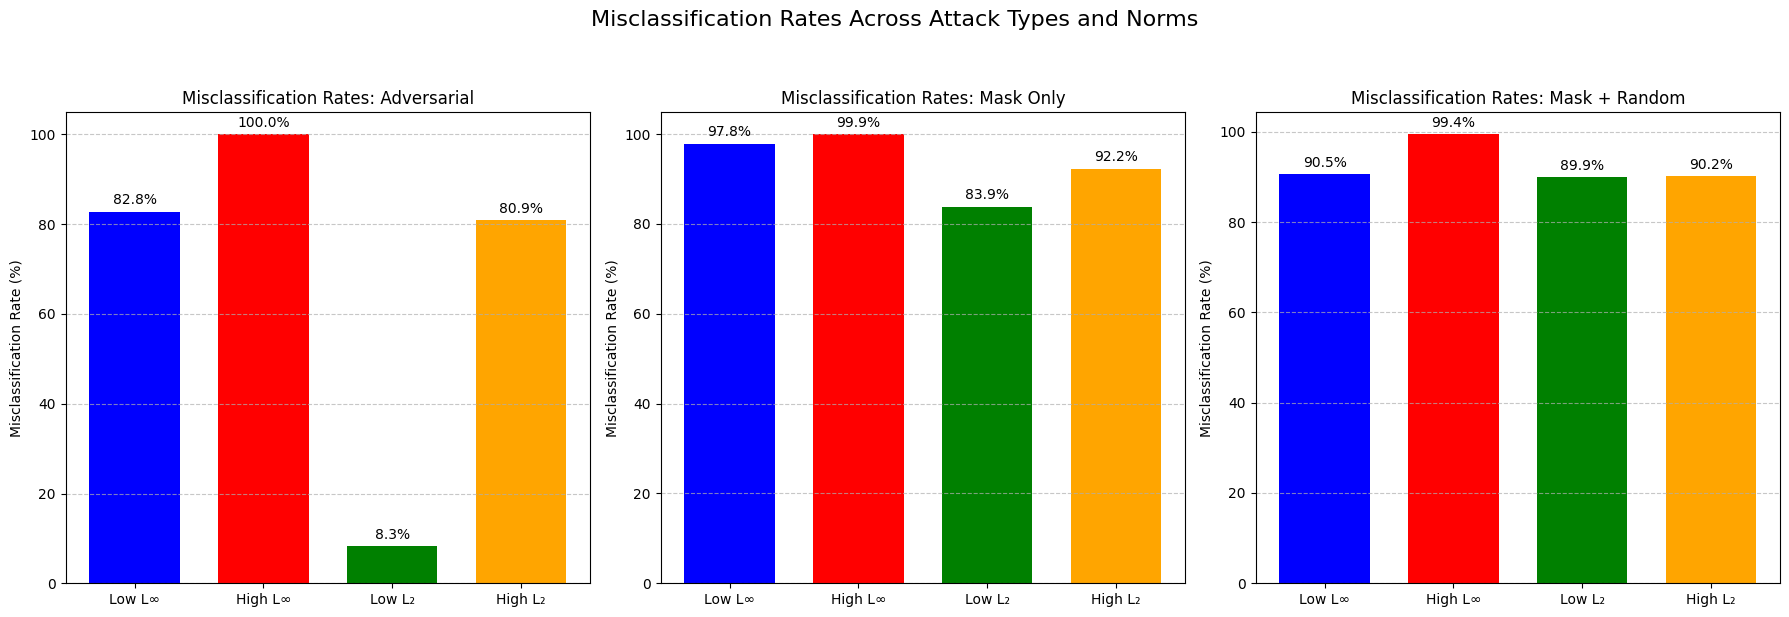

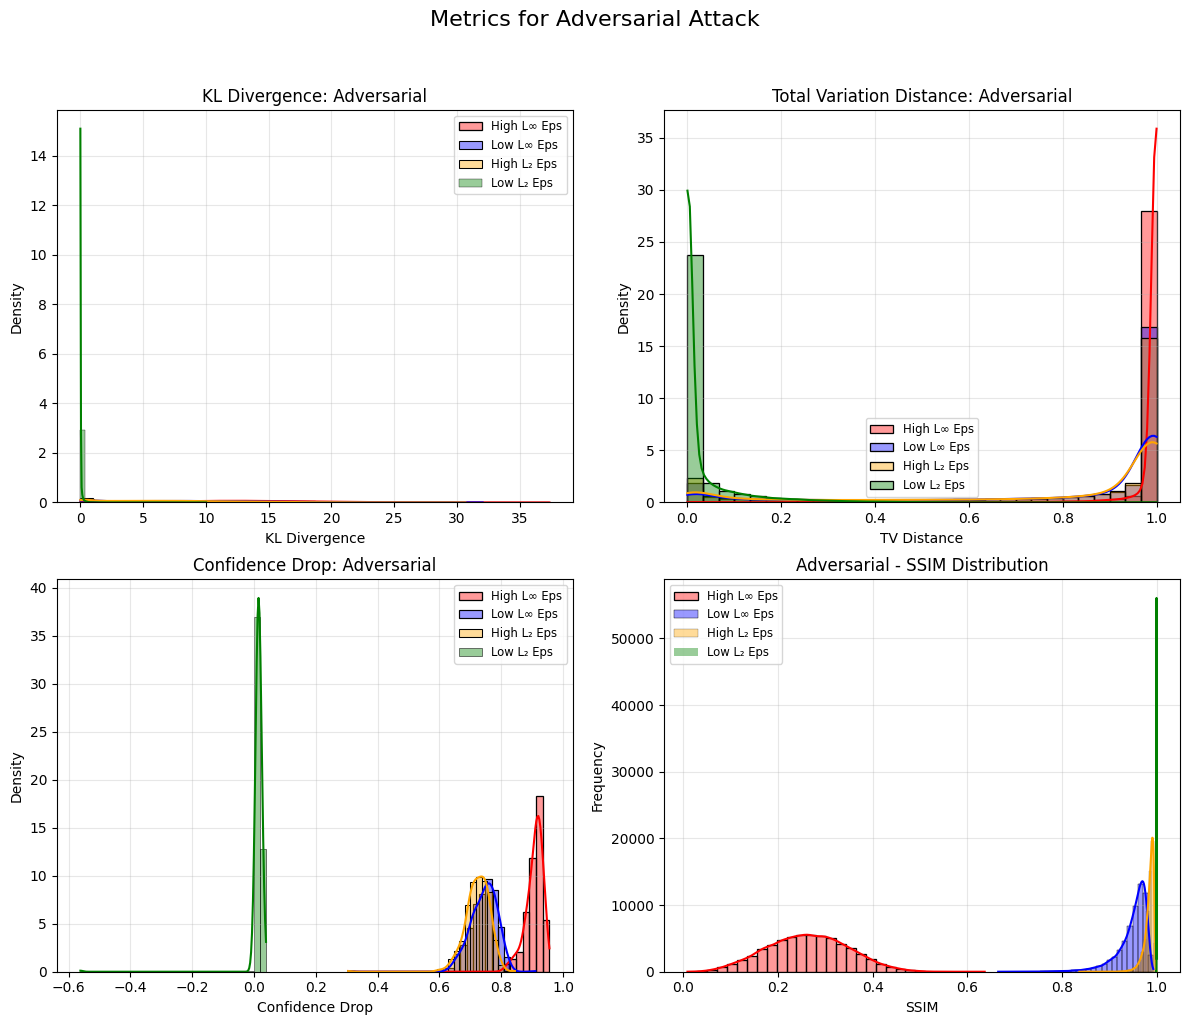

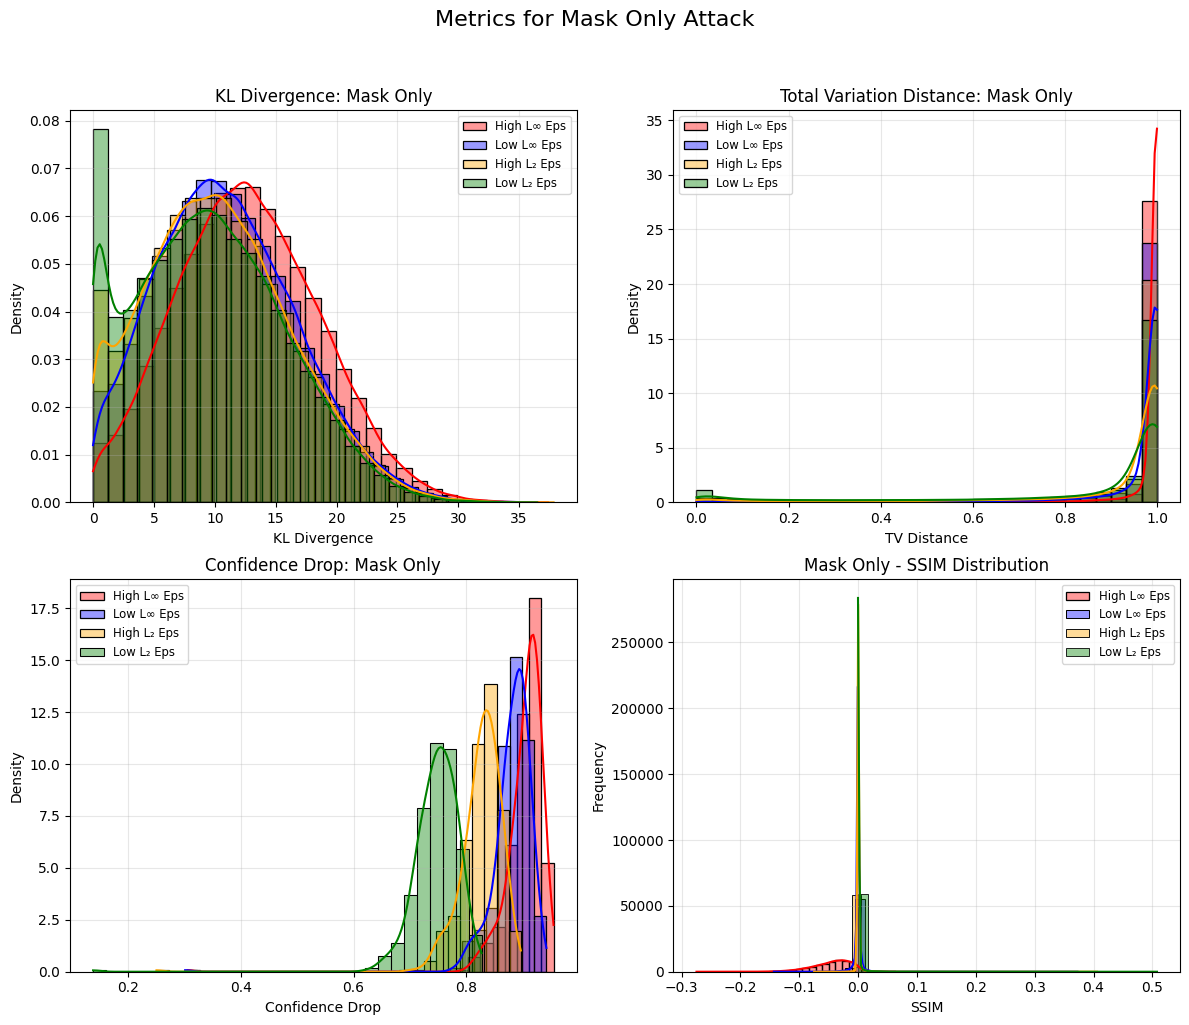

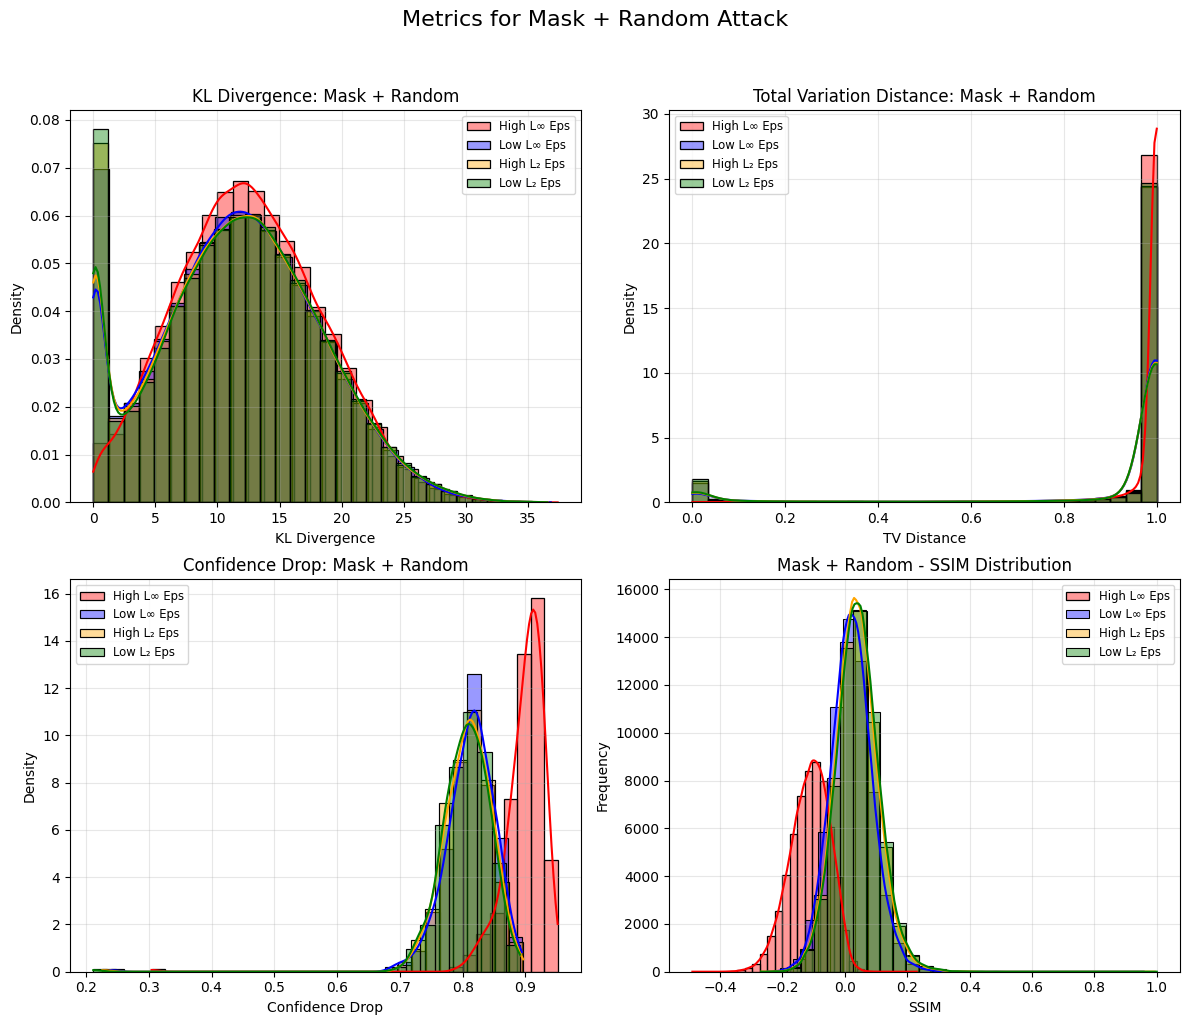

In [7]:
main_plotting_function(clean_images, linf_image_data, l2_image_data, npz_data)